## **Semantic Segmentation**

Semantic Segmentation เป็นการทำนาย class ของ pixel ในภาพว่าแต่ละ pixel คือภาพประเภทอะไร เช่น ในกรณีของพาหนะขับเคลื่อนอัตโนมัติ เราอาจจะนำ Semantic segmentation มาใช้แยกประเภทของสิ่งต่างๆบนถนนก็ได้ เช่น รั้ว รถยนต์ จักรยาน และอื่นๆ

ในตัวอย่างนี้เราจะใช้ชุดข้อมูลตัวอย่าง `CAMVID` (http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/) ซึ่งเป็นข้อมูลที่เก็บจากภาพบนท้องถนนจากเมืองเคมบริดจ์ จากนั้นมีการเก็บข้อมูลเพื่อแยกว่าแต่ละ pixel เป็นภาพชนิดอะไรจาก 32 classes หลัก

ใครที่สนใจเพิ่มเติมสามารถดูตัวอย่างได้จาก Icevision library ได้ตามด้านล่าง:
Reference: https://airctic.com/dev/getting_started_semantic_segmentation/

In [3]:
from icevision.all import *

INFO     - The mmdet config folder already exists. No need to downloaded it. Path : /home/tupleteam/.icevision/mmdetection_configs/mmdetection_configs-2.20.1/configs | icevision.models.mmdet.download_configs:download_mmdet_configs:17
INFO     - The mmseg config folder already exists. No need to downloaded it. Path : /home/tupleteam/.icevision/mmsegmentation_configs/mmsegmentation_configs-0.17.0/configs | icevision.models.mmseg.download_configs:download_mmseg_configs:19


In [4]:
data_url = 'https://s3.amazonaws.com/fast-ai-sample/camvid_tiny.tgz'
data_dir = icedata.load_data(data_url, 'camvid_tiny') / 'camvid_tiny'

In [5]:
codes = np.loadtxt(data_dir/'codes.txt', dtype=str)
class_map = ClassMap(list(codes))

In [6]:
class_map

<ClassMap: {'background': 0, 'Animal': 1, 'Archway': 2, 'Bicyclist': 3, 'Bridge': 4, 'Building': 5, 'Car': 6, 'CartLuggagePram': 7, 'Child': 8, 'Column_Pole': 9, 'Fence': 10, 'LaneMkgsDriv': 11, 'LaneMkgsNonDriv': 12, 'Misc_Text': 13, 'MotorcycleScooter': 14, 'OtherMoving': 15, 'ParkingBlock': 16, 'Pedestrian': 17, 'Road': 18, 'RoadShoulder': 19, 'Sidewalk': 20, 'SignSymbol': 21, 'Sky': 22, 'SUVPickupTruck': 23, 'TrafficCone': 24, 'TrafficLight': 25, 'Train': 26, 'Tree': 27, 'Truck_Bus': 28, 'Tunnel': 29, 'VegetationMisc': 30, 'Void': 31, 'Wall': 32}>

In [7]:
images_dir = data_dir/'images'
labels_dir = data_dir/'labels'
image_files = get_image_files(images_dir)

In [8]:
records = RecordCollection(SemanticSegmentationRecord)

for image_file in pbar(image_files):
    record = records.get_by_record_id(image_file.stem)

    if record.is_new:
        record.set_filepath(image_file)
        record.set_img_size(get_img_size(image_file))
        record.segmentation.set_class_map(class_map)

    mask_file = SemanticMaskFile(labels_dir / f'{image_file.stem}_P.png')
    record.segmentation.set_mask(mask_file)

records = records.autofix()
train_records, valid_records = records.make_splits(RandomSplitter([0.8, 0.2]))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

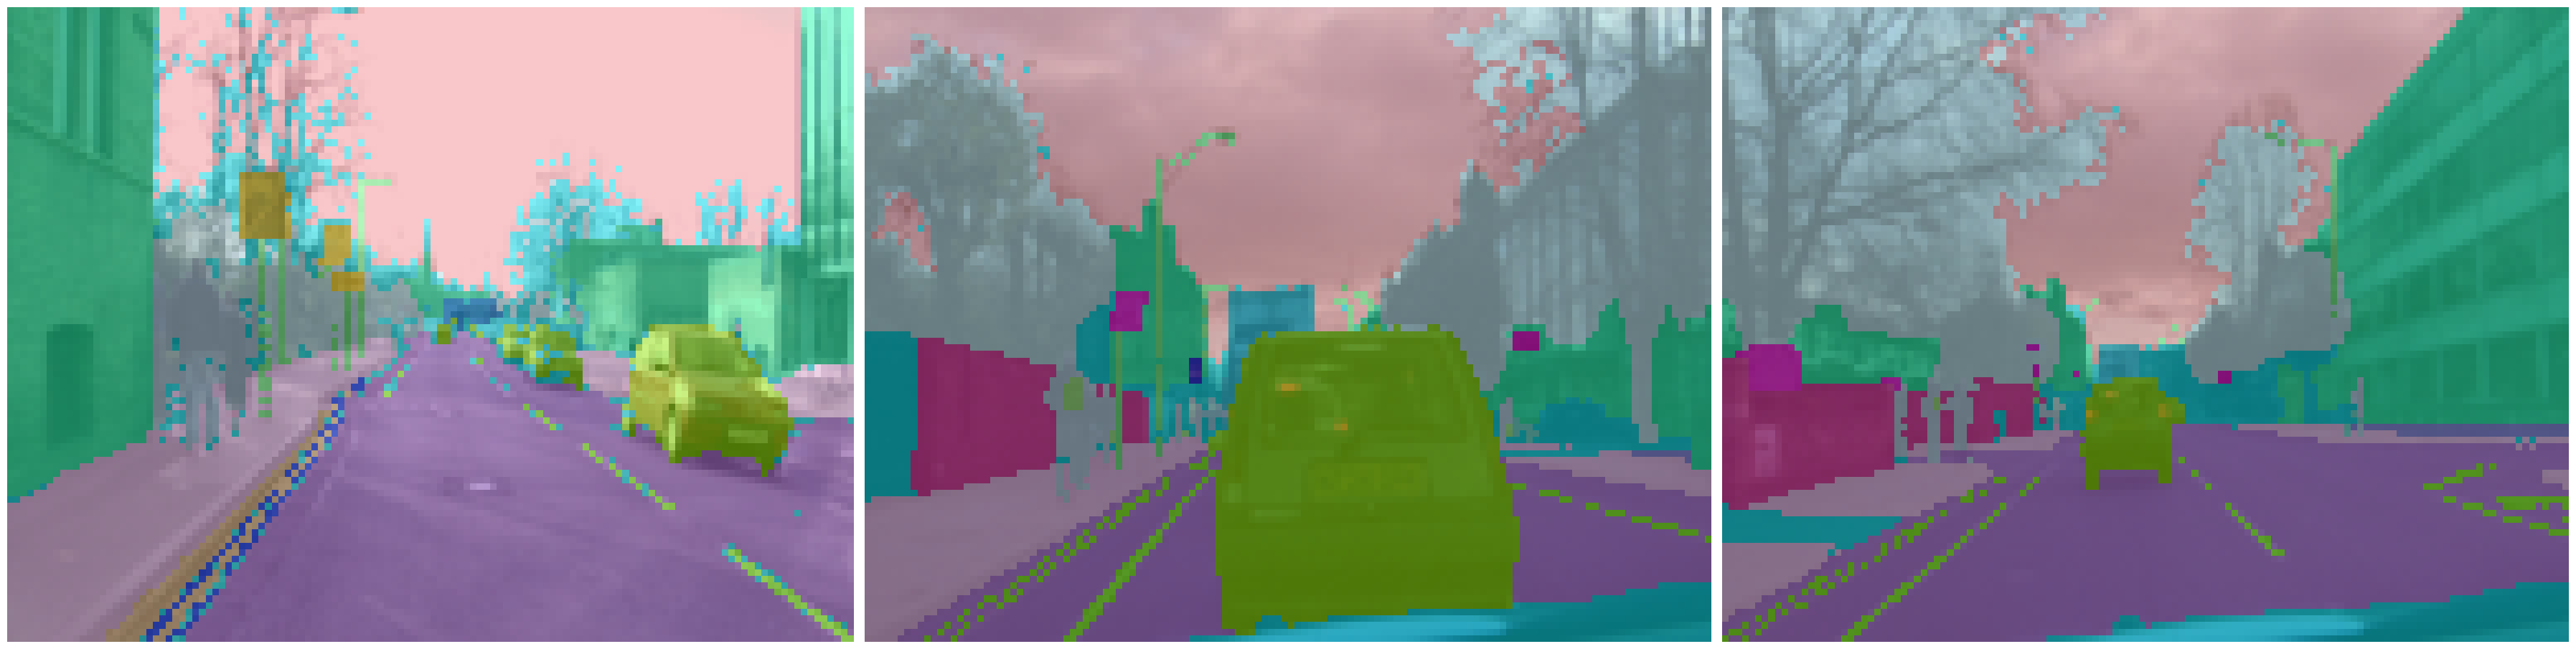

In [9]:
sample_records = random.choices(records, k=3)
show_records(sample_records, ncols=3)

In [10]:
presize, size = 512, 384
presize, size = ImgSize(presize, int(presize*.75)), ImgSize(size, int(size*.75))

aug_tfms = tfms.A.aug_tfms(
    presize=presize, size=size, pad=None,
    crop_fn=partial(tfms.A.RandomCrop, p=0.5),
    shift_scale_rotate=tfms.A.ShiftScaleRotate(rotate_limit=2),
)
train_tfms = tfms.A.Adapter([*aug_tfms, tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([tfms.A.resize(size), tfms.A.Normalize()])

In [11]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

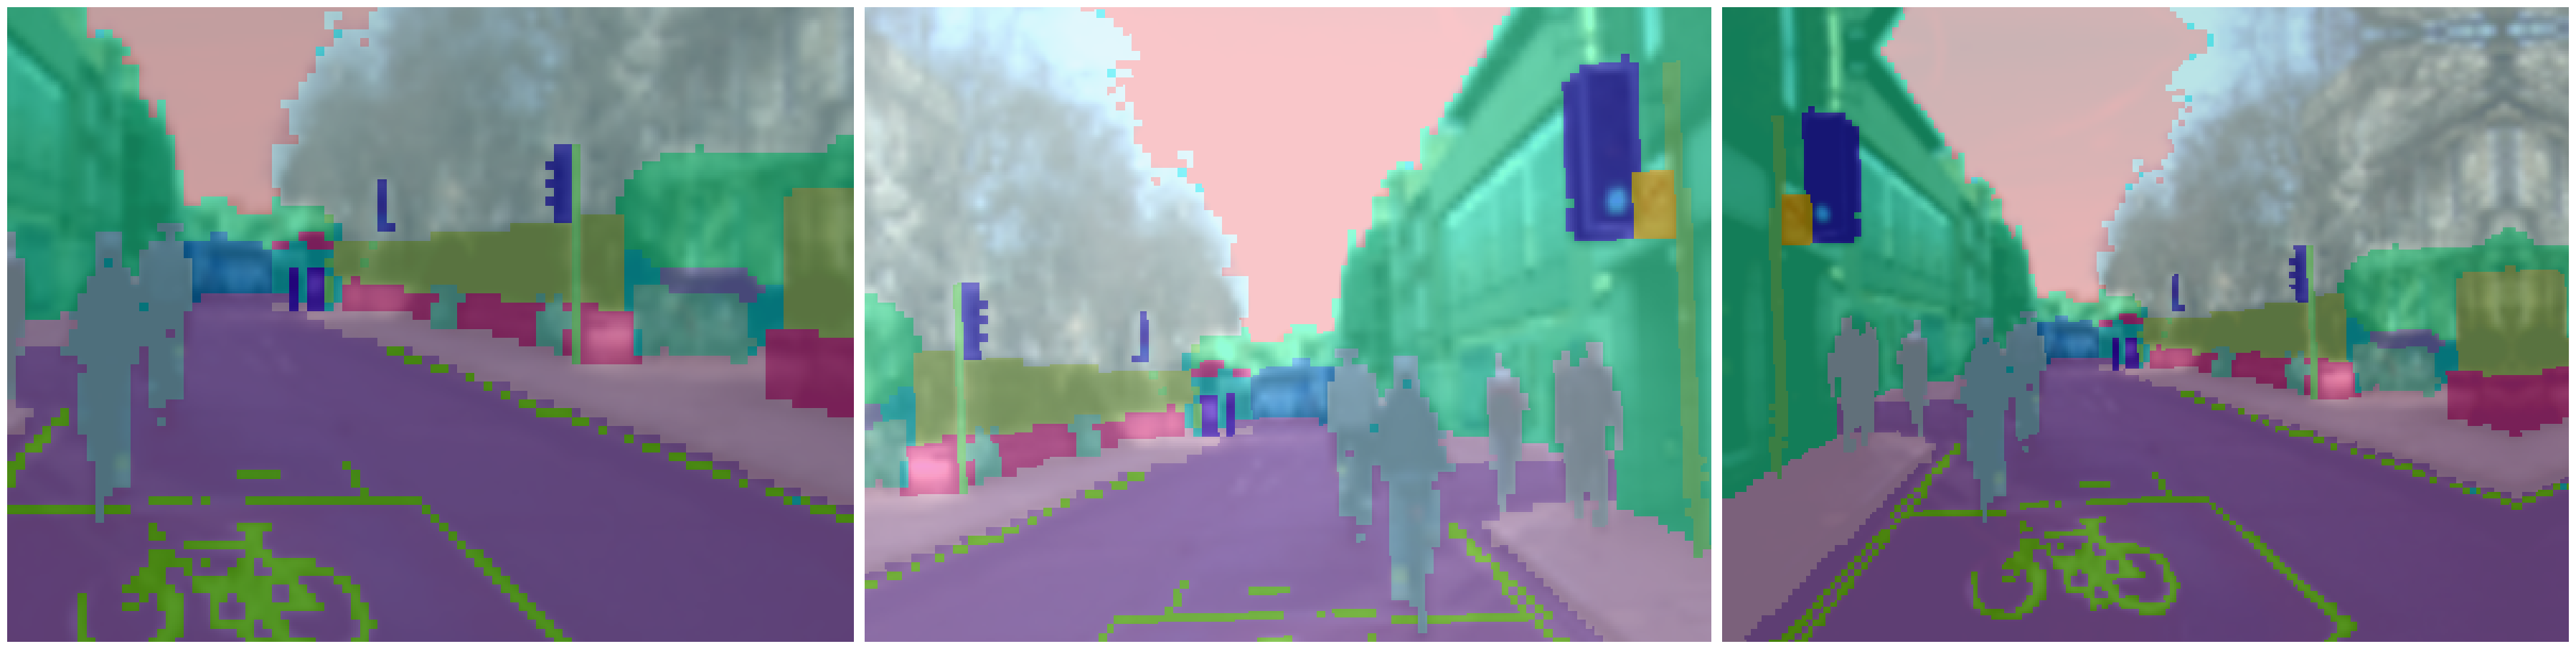

In [12]:
ds_samples = [train_ds[0] for _ in range(3)]
show_samples(ds_samples, ncols=3)

In [40]:
model_type = models.fastai.unet
backbone = model_type.backbones.resnet34()

model = model_type.model(
    backbone=backbone,
    num_classes=class_map.num_classes,
    img_size=size
)

In [41]:
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)

## **Peeking inside dataloader**

In [50]:
img, _ = next(iter(train_dl))

In [51]:
img[0].shape, img[1].shape

(torch.Size([8, 3, 288, 384]), torch.Size([8, 288, 384]))

In [53]:
pred_img = model(img[0])

In [55]:
pred_img.shape

torch.Size([8, 33, 288, 384])

## **Training semantic segmentation model**

In [56]:
def accuracy_camvid(pred, target):
    # ignores void pixels
    keep_idxs = target != class_map.get_by_name('Void')
    target = target[keep_idxs]
    pred = pred.argmax(dim=1)[keep_idxs]

    return (pred==target).float().mean() 

In [57]:
learner = model_type.fastai.learner(
    dls=[train_dl, valid_dl],
    model=model,
    metrics=[accuracy_camvid]
)

SuggestedLRs(valley=0.00010964782268274575)

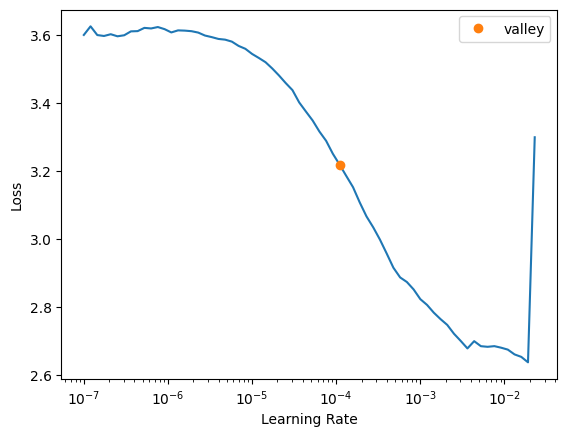

In [58]:
learner.lr_find()

In [59]:
learner.fine_tune(30, 5e-4, freeze_epochs=3)

epoch,train_loss,valid_loss,accuracy_camvid,time
0,3.057316,2.418862,0.461984,00:03
1,2.503373,1.739964,0.626879,00:03
2,2.137541,1.348224,0.629642,00:03


epoch,train_loss,valid_loss,accuracy_camvid,time
0,1.324122,1.218956,0.656001,00:03
1,1.263109,1.115377,0.688073,00:03
2,1.201592,1.032354,0.711250,00:03
3,1.140353,0.950475,0.745734,00:03
4,1.083756,0.988958,0.734069,00:03
5,1.046421,0.934117,0.758120,00:03
6,1.021480,0.886979,0.767783,00:03
7,0.985285,0.830630,0.779449,00:03
8,0.955090,0.821257,0.786345,00:03
9,0.917587,0.765292,0.802953,00:03


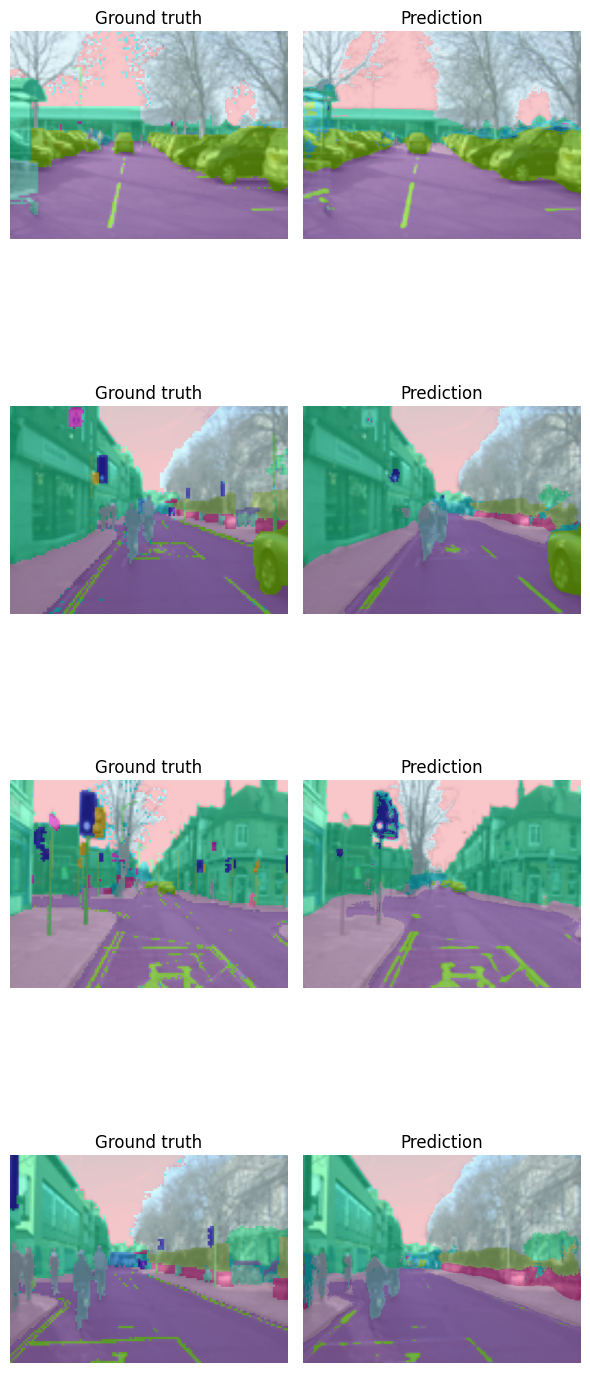

In [60]:
model_type.show_results(model, valid_ds, num_samples=4)